In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import scipy

In [2]:
import scipy.io
import matplotlib.pyplot as plt
import random

<p>Here's the description from the paper</p>
<img src="EEGNet.png" style="width: 700px; float:left;">

In [3]:
## the following data is filtered
TRAIN_A = 'data/BCI_Comp_III_Wads_2004/Subject_A_Train1.mat'
TRAIN_B = 'data/BCI_Comp_III_Wads_2004/Subject_B_Train1.mat'


#TRUE_LABELS_A = 'WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU'
#TRUE_LABELS_B = 'MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR'

MATRIX = ['abcdef',
          'ghijkl',
          'mnopqr',
          'stuvwx',
          'yz1234',
          '56789_']

screen=[['A','B','C','D','E','F'],
            ['G','H','I','J','K','L'],
            ['M','N','O','P','Q','R'],
            ['S','T','U','V','W','X'],
            ['Y','Z','1','2','3','4'],
            ['5','6','7','8','9','_']]

print (screen)
print (len(screen))

[['A', 'B', 'C', 'D', 'E', 'F'], ['G', 'H', 'I', 'J', 'K', 'L'], ['M', 'N', 'O', 'P', 'Q', 'R'], ['S', 'T', 'U', 'V', 'W', 'X'], ['Y', 'Z', '1', '2', '3', '4'], ['5', '6', '7', '8', '9', '_']]
6


In [4]:
def load_dataset(SUBJECT,flag):
    
    data=scipy.io.loadmat(SUBJECT)
    
    #print ('Subject A dataa',data)
    Signal=np.float32(data['Signal'])
    #print ('signal',Signal, Signal.shape)

    Flashing=np.float32(data['Flashing'])
    #print ('flashing',Flashing, Flashing.shape)

    StimulusCode=np.float32(data['StimulusCode'])
    #print ('Stimulus COde',StimulusCode,StimulusCode.shape)
    if flag==0:
        StimulusType=np.float32(data['StimulusType'])
        #print ('Stimulus type',StimulusType,StimulusType.shape)

        Target=data['TargetChar']# array([ 'EAEVQTDOJG8RBRGONCEDHCTUIDBPUHMEM6OUXOCFOUKWA4VJEFRZROLHYNQDW_EKTLBWXEPOUIKZERYOOTHQI'],4
        #print ('Target char for subjectA',Target)

        return Signal,Flashing,StimulusCode,StimulusType,Target

    else:
         return Signal,Flashing,StimulusCode


In [5]:
Signal_A,Flashing_A,StimulusCode_A,StimulusType_A,Target_A=load_dataset(TRAIN_A,0)
print ('Signal A shape',Signal_A.shape)
train_char_size=Signal_A.shape[0]

#############################################################################################
Signal_B,Flashing_B,StimulusCode_B,StimulusType_B,Target_B=load_dataset(TRAIN_B,0)


Signal A shape (85, 7794, 64)


In [6]:
### DEFINE P300 WIndow size
window=48  # take a window to get no of datapoints corresponding to 600 ms after onset of stimuli 
T=int(3*window)
print(window/2.0)

24.0


In [7]:
#Split training into hold and validation
def create_subset(NtrainIm,NtrainL):

    #Creating a hold out set and remaining set out of the new training set..
    NtrainIm_hold = []
    NtrainL_hold = []
    NtrainIm_rem = []
    NtrainL_rem = []
    #print(int(len(NtrainIm)/10))
    Random = random.sample(range(0, NtrainIm.shape[0]), np.int(0.12*NtrainIm.shape[0]))
    for k in range(0,NtrainIm.shape[0]):
        if k in Random:
            NtrainIm_hold.append(NtrainIm[k,:])
            NtrainL_hold.append(NtrainL[k])
        else:
            NtrainIm_rem.append(NtrainIm[k,:])
            NtrainL_rem.append(NtrainL[k])
    NtrainIm_hold = np.array(NtrainIm_hold)
    NtrainL_hold = np.array(NtrainL_hold)
    NtrainIm_rem = np.array(NtrainIm_rem)
    NtrainL_rem = np.array(NtrainL_rem)
    
    return np.array(NtrainIm_rem),np.array(NtrainIm_hold),np.array(NtrainL_rem),np.array(NtrainL_hold)
    

def format_data(Signal,Flashing,StimulusCode,StimulusType,Target):
    
    char_size=Signal.shape[0]
    responses=np.zeros([char_size,12,15,T,64])
    
    for epoch in range(0,Signal.shape[0]):
        count=1;
        rowcolcnt=np.zeros(12)
        for n in range(1,Signal.shape[1]):
            # detect location of sample immediately after the stimuli
            if Flashing[epoch,n]==0 and Flashing[epoch,n-1]==1:
                rowcol=int(StimulusCode[epoch,n-1])-1
                #print (Signal[epoch,n:n+window,:].shape)
               # print (rowcolcnt[int(rowcol)])
                responses[epoch,int(rowcol),int(rowcolcnt[int(rowcol)]),:,:]=Signal[epoch,n-int(window/2):n+ int(2.5*window),:]
                rowcolcnt[rowcol]=rowcolcnt[rowcol]+1
                #print (rowcolcnt)
        #print (epoch)
    print ('Response for all characters',responses.shape)

    #####################################################################################################################
    ### Taking average over 15 instances of the 12 stimuli, comment to check performance and increase the dataset size- TO DO
    trainset=np.mean(responses, axis=2)
    print ('trainset',trainset.shape)
    
    #####################################################################################################################
    #target_ohe=np.zeros([len(Target[0]),36])
    stimulus_indices=[]
    for n_char in range(0,len(Target[0])):  #character epochs

        #print (Target[0][n_char])
        #vv=np.where(screen==str(Target[0][n_char]))
        #print (vv)
        #[row,col]
        for row in range(0,6):
            for col in range(0,6):
                #print (screen[row][col])
                if (Target[0][n_char]) is (screen[row][col]):
                    ind=[row+7,col+1]
                    stimulus_indices.append(ind)
                    #print (ind)
    #print (len(stimulus_indices))
    print ('Splitting P300 and non-P300 dataset...')
    # iterate over the 2nd dimension of trainset:trainset (train_char_size, 12, 42, 64) and split as train_char_size*2*42*64 and train_char_size*10*42*64
    
    P300_dataset=np.zeros([train_char_size,2,T,64])
    non_P300_dataset=np.zeros([train_char_size,10,T,64])

    for char_epoch in range(0,trainset.shape[0]):
        # choose the i,j out of the 2nd dimension of trainset where i,j comes from stimulus_indices[char_epoch]
        ind_1=stimulus_indices[char_epoch][0]
        ind_2=stimulus_indices[char_epoch][1]
        #print (ind_1,ind_2)
        l=0
        for index in range(0,12):
            if index==ind_1-1 or index==ind_2-1 :
                P300_dataset[char_epoch,0,:,:]=trainset[char_epoch,ind_1-1,:,:]
                P300_dataset[char_epoch,1,:,:]=trainset[char_epoch,ind_2-1,:,:]


            else:
                #print ('here')
                #print (index)
                non_P300_dataset[char_epoch,l,:,:]=trainset[char_epoch,index,:,:]
               # targets_A[char_epoch,index]=0

                l=l+1

    #print (np.all(P300_dataset[0,0,:,:])==np.all(trainset[0,5,:,:]))
    print (P300_dataset.shape)
    print (non_P300_dataset.shape)
    #85, 2, 128, 64)
    #(85, 10, 128, 64)
    '''
    for p in range(0,2):
        print ('next P300')
        for n_p in range(0,10):
            plt.figure()
            #plt.subplot(121)
            plt.plot(P300_dataset[0,p,:,5].T)
            #plt.figure()
            #plt.subplot(122)
            plt.plot(non_P300_dataset[0,n_p,:,5].T)
            plt.show()  
    '''
    return P300_dataset,non_P300_dataset

##


In [8]:
## TO DO :
### REPEAT CODE IN THIS CELL FOR TRAINING SUBJECT B, ignore variables named as A for now

# this for loop is jsut for printing, either make a function or copy paste to get B data


subject = '1'#raw_input('Enter subject you want to train(A: 0 or B:1 ):  ')    
if subject=='1':
    print ('For subject A')
    P300_dataset_,non_P300_dataset_=format_data(Signal_A,Flashing_A,StimulusCode_A,StimulusType_A,Target_A)
else:
    print ('For subject B')
    P300_dataset_,non_P300_dataset_=format_data(Signal_B,Flashing_B,StimulusCode_B,StimulusType_B,Target_B)


    
targets_=np.zeros([train_char_size*15,12])
targets_[:,0:2]=1 ; targets_[:,2:12]=0


## Create training and validation subset
P300_train_,P300_hold_, P300_train_label_, P300_hold_label_=create_subset(np.reshape(P300_dataset_,[train_char_size*2,T,64]),np.reshape(targets_[:,0:2],[train_char_size*2*15,1]))

non_P300_train_,non_P300_hold_, non_P300_train_label_, non_P300_hold_label_=create_subset(np.reshape(non_P300_dataset_,[train_char_size*10,T,64]),np.reshape(targets_[:,2:12],[train_char_size*10*15,1]))
print('-----------------------------------------------------------------------------------------------------------')

print ('Training set of P300 samples')
print (P300_train_.shape,P300_train_label_.shape)   

print ('\nValidation set of P300 samples')
print (P300_hold_.shape,P300_hold_label_.shape)   

print ('\nTraining set of non-P300 samples')
print (non_P300_train_.shape,non_P300_train_label_.shape)  

print ('\nValidation set of non- P300 samples')
print (non_P300_hold_.shape,non_P300_hold_label_.shape) 

print('-----------------------------------------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------------------------------------')



For subject A
Response for all characters (85, 12, 15, 144, 64)
trainset (85, 12, 144, 64)
Splitting P300 and non-P300 dataset...
(85, 2, 144, 64)
(85, 10, 144, 64)
-----------------------------------------------------------------------------------------------------------
Training set of P300 samples
(150, 144, 64) (150, 1)

Validation set of P300 samples
(20, 144, 64) (20, 1)

Training set of non-P300 samples
(748, 144, 64) (748, 1)

Validation set of non- P300 samples
(102, 144, 64) (102, 1)
-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


In [9]:
def shuffle(trainIm_rem,trainL_rem): 
    
    
    NtrainIm_hold = []
    NtrainL_hold = []
  
    R = random.sample(range(0, trainIm_rem.shape[0]),trainIm_rem.shape[0])

    for k in R:
        #print (k)
        NtrainIm_hold.append(trainIm_rem[k,:,:])
        NtrainL_hold.append(trainL_rem[k,:])
    
    return np.array(NtrainIm_hold),np.array(NtrainL_hold)

# AGAIN IGNORE THE NAMING CONVENTION WHICH IS BY DEFAULT A
def choose_subsection_non_P300(a,b,c,d,P300_train,non_P300_train,P300_hold,non_P300_hold ):
        
        print (a,b,c,d)
        t1 = 2 * P300_train.shape[0]  # + non_P300_train_A.shape[0] #909
       
        t2 = P300_train.shape[0] #152
        
        if b == non_P300_train.shape[0] :
            t1=t1-2
            
        dataset_A_train=np.zeros([t1,T,64])
        dataset_A_train[0:t2,:,:]=P300_train
       
        dataset_A_train[t2:t1,:,:]=non_P300_train[a:b,:,:]

        targets_A_train=np.zeros([t1,1])
        targets_A_train[0:t2,:]=1

        h1 = 2 * P300_hold.shape[0] #+ non_P300_hold_label_A.shape[0] #111
        h2 = P300_hold.shape[0] #18
             
        if d == non_P300_hold.shape[0] :
            h1=h1 + 2
       
            
        dataset_A_hold=np.zeros([h1,T,64])
        dataset_A_hold[0:h2,:,:]=P300_hold
        
        dataset_A_hold[h2:h1:,:]=non_P300_hold[c:d,:,:]
        targets_A_hold=np.zeros([h1,1])
        targets_A_hold[0:h2,:]=1
        
        
        #print(targets_A_hold.shape)

        ### SHUFFLE ABOVE DATASET and LABELS
        print ('-------------------------HOLD AND TRAIN DATASET_CNN READY----------------------------------------------')
        dataset_A_hold,targets_A_hold=shuffle(dataset_A_hold,targets_A_hold)
        print (dataset_A_hold.shape,targets_A_hold.shape)

        dataset_A_train,targets_A_train=shuffle(dataset_A_train,targets_A_train)
        print (dataset_A_train.shape,targets_A_train.shape)
        print ('--------------------------------------------------------------------------------------------------------')
        ################################

        return dataset_A_train,targets_A_train,dataset_A_hold,targets_A_hold 
    
def create_balanced_dataset(P300_train_A,non_P300_train_A,P300_hold_A,non_P300_hold_A):

    #######################################################
    #Combine the dataset:
    # Part 1: 
    a=0;b=int(np.ceil(non_P300_train_A.shape[0]/5));    c=0;d=int(non_P300_hold_A.shape[0]/5)
    dataset_A_train_1,targets_A_train_1,dataset_A_hold_1,targets_A_hold_1 = choose_subsection_non_P300(a,b,c,d,P300_train_A,non_P300_train_A,P300_hold_A,non_P300_hold_A)
     
    # Part 2: 
    a=int(np.ceil(non_P300_train_A.shape[0]/5));b=2 *int(np.ceil(non_P300_train_A.shape[0]/5))
    c=int(non_P300_hold_A.shape[0]/5); d= 2* int(non_P300_hold_A.shape[0]/5)
    dataset_A_train_2,targets_A_train_2,dataset_A_hold_2,targets_A_hold_2 = choose_subsection_non_P300(a,b,c,d,P300_train_A,non_P300_train_A,P300_hold_A,non_P300_hold_A)
  
    # Part 3: 
    a=2 * int(np.ceil(non_P300_train_A.shape[0]/5));b=3 *int(np.ceil(non_P300_train_A.shape[0]/5))
    c=2 * int(non_P300_hold_A.shape[0]/5); d= 3* int(non_P300_hold_A.shape[0]/5)
    dataset_A_train_3,targets_A_train_3,dataset_A_hold_3,targets_A_hold_3 = choose_subsection_non_P300(a,b,c,d,P300_train_A,non_P300_train_A,P300_hold_A,non_P300_hold_A)
  
    # Part 4: 
    a=3 * int(np.ceil(non_P300_train_A.shape[0]/5));b=4 *int(np.ceil(non_P300_train_A.shape[0]/5))
    c=3 * int(non_P300_hold_A.shape[0]/5); d= 4* int(non_P300_hold_A.shape[0]/5)
    dataset_A_train_4,targets_A_train_4,dataset_A_hold_4,targets_A_hold_4 = choose_subsection_non_P300(a,b,c,d,P300_train_A,non_P300_train_A,P300_hold_A,non_P300_hold_A)
  
    # Part 5: 
    a=4 * int(np.ceil(non_P300_train_A.shape[0]/5));b=5 *int(np.ceil(non_P300_train_A.shape[0]/5)) - 2
    c=4 * int(non_P300_hold_A.shape[0]/5); d= 5* int(non_P300_hold_A.shape[0]/5) +2 
    dataset_A_train_5,targets_A_train_5,dataset_A_hold_5,targets_A_hold_5 = choose_subsection_non_P300(a,b,c,d,P300_train_A,non_P300_train_A,P300_hold_A,non_P300_hold_A)
  
    return dataset_A_train_1,targets_A_train_1,dataset_A_hold_1,targets_A_hold_1,dataset_A_train_2,targets_A_train_2,dataset_A_hold_2,targets_A_hold_2 ,dataset_A_train_3,targets_A_train_3,dataset_A_hold_3,targets_A_hold_3,dataset_A_train_4,targets_A_train_4,dataset_A_hold_4,targets_A_hold_4,dataset_A_train_5,targets_A_train_5,dataset_A_hold_5,targets_A_hold_5
    

dataset_A_train_1,targets_A_train_1,dataset_A_hold_1,targets_A_hold_1,dataset_A_train_2,targets_A_train_2,dataset_A_hold_2,targets_A_hold_2,dataset_A_train_3,targets_A_train_3,dataset_A_hold_3,targets_A_hold_3,dataset_A_train_4,targets_A_train_4,dataset_A_hold_4,targets_A_hold_4,dataset_A_train_5,targets_A_train_5,dataset_A_hold_5,targets_A_hold_5 = create_balanced_dataset(P300_train_,non_P300_train_,P300_hold_,non_P300_hold_)

#dataset_B_train,targets_B_train,dataset_B_hold,targets_B_hold; use if subject B is used to calculate P300_train_ etc.  
    


0 150 0 20
-------------------------HOLD AND TRAIN DATASET_CNN READY----------------------------------------------
(40, 144, 64) (40, 1)
(300, 144, 64) (300, 1)
--------------------------------------------------------------------------------------------------------
150 300 20 40
-------------------------HOLD AND TRAIN DATASET_CNN READY----------------------------------------------
(40, 144, 64) (40, 1)
(300, 144, 64) (300, 1)
--------------------------------------------------------------------------------------------------------
300 450 40 60
-------------------------HOLD AND TRAIN DATASET_CNN READY----------------------------------------------
(40, 144, 64) (40, 1)
(300, 144, 64) (300, 1)
--------------------------------------------------------------------------------------------------------
450 600 60 80
-------------------------HOLD AND TRAIN DATASET_CNN READY----------------------------------------------
(40, 144, 64) (40, 1)
(300, 144, 64) (300, 1)
--------------------------------

In [10]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1,64), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        #self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.conv2 = nn.Conv2d(1, 4, (8, 8))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 144 timepoints. 
        #4, 2, 487
        self.fc1 = nn.Linear(4*1*10, 1) #4,1,10
        

    def forward(self, x):
        # Layer 1
      #  x = x.double()
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        #print (x.size())
        # FC Layer
        x = x.view(-1,4 *1 * 10)# 4*2*9) # for T=128
        #x = x.view(-1,4 *2 * 9)# 4*2*9) # for T=128
        x = F.sigmoid(self.fc1(x))
        return x


net = EEGNet()#.cuda(0)
#print (net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 120, 64)))))#.cuda(0))))
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

In [11]:
def train(epoch,X_train1,y_train1):
        running_loss=0.0
        # Mini batch training
        print ('BS',batch_size)
        for i in range(0,len(X_train1),batch_size):       
            #print ('Epocj,mini-batch',epoch,i)
            inputs = torch.from_numpy(X_train1[i:i+batch_size])
            labels = torch.FloatTensor(y_train1[i:i+batch_size]*1.0)

           # print (labels.size())
            # wrap them in Variable
            #inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            #print ('op',outputs.size())
            #print('labels',labels.size())
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.data[0]
             # for graphing puposes
            running_loss_array.append(loss.data[0])
        
        
            #print the current status of training
            #if(i % 128 == 0):
             #   print('Train Epoch',epoch,'Mini batch:',i, '\tLoss',loss.data[0])

        return running_loss_array


In [12]:
####  for validation and testing 
def valid(net,epoch,X_val1,y_val1):
    
    predicted_loss=[]
   
    inputs = torch.from_numpy(X_val1)
    labels = torch.FloatTensor(y_val1*1.0)

    inputs, labels = Variable(inputs), Variable(labels)

    '''
    output = net(data)
    valid_loss = valid_loss + F.nll_loss(output, target, size_average=False).data[0] 
    pred = output.data.max(1, keepdim=True)[1]
    correct = correct + pred.eq(target.data.view_as(pred)).cpu().sum() 
    '''
    ########################   
    #print (inputs.size())
    results = []
   
    predicted = []
   
    #inputs = Variable(torch.from_numpy(X_val1))#.cuda(0))
    predicted = net(inputs)

    predicted = predicted.data.cpu().numpy()
    #from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
    #print ('predicted',predicted.shape)
    #print ('predicted',predicted)
    Y=labels.data.numpy()
   # print ('Y',Y)
    for param in ["acc", "auc", "recall", "precision","fmeasure"]:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
     
   # print (len(results))
    return predicted, results #validation_loss_array


In [13]:
batch_size= 4
Epochs=10

In [14]:

## This testdata is filtered first in matlab and then used and loaded over here 

dataset_test=scipy.io.loadmat('test_set_A_processed.mat')['data']
targets_test=scipy.io.loadmat('true_labels_A_processed.mat')['labels']

(300, 1, 144, 64)
-------------
(300, 1)
------------------------------
(40, 1, 144, 64)
-------------
(40, 1)
-------------
(1200, 1)

Epoch  0
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.69999999999999996, 0.755, 0.69999999999999996, 0.69999999999999996, 0.69999999999999996]
test_results [0.66583333333333339, 0.83920000000000006, 0.83499999999999996, 0.3121495327102804, 0.45442176870748302]

Epoch  1
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.84999999999999998, 0.89500000000000002, 0.84999999999999998, 0.84999999999999998, 0.84999999999999998]
test_results [0.77833333333333332, 0.9125899999999999, 0.88500000000000001, 0.42142857142857143, 0.57096774193548383]

Epoch  2
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.875, 0.90249999999999997, 0.90000000000000002, 0.8571428571428571, 0.87804878048780477]
test_results [0.80333333333333334, 0.92859999999999987, 0.

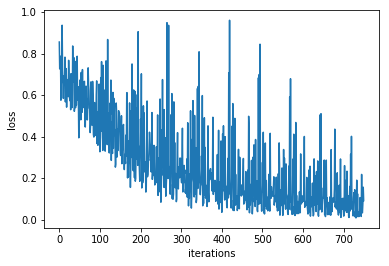

(40, 1) (40, 1)


In [15]:
############## CLASSIFIER I : 

#dataset_A_hold.shape,targets_A_hold.shape

X_train = np.reshape(dataset_A_train_1,[dataset_A_train_1.shape[0],1,dataset_A_train_1.shape[1],dataset_A_train_1.shape[2]]).astype('float32')
y_train = np.reshape(targets_A_train_1,[targets_A_train_1.shape[0],1]).astype('float32')

X_val = np.reshape(dataset_A_hold_1,[dataset_A_hold_1.shape[0],1,dataset_A_hold_1.shape[1],dataset_A_hold_1.shape[2]]).astype('float32') 
y_val = np.reshape(targets_A_hold_1,[targets_A_hold_1.shape[0],1]).astype('float32')

X_test = np.reshape(dataset_test,[dataset_test.shape[0],1,dataset_test.shape[1],dataset_test.shape[2]]).astype('float32')  #np.random.rand(100*12,1, 42, 64).astype('float32')
y_test = np.reshape(targets_test,[targets_test.shape[0],1]).astype('float32')


print (X_train.shape)

print ('-------------')
print (y_train.shape)

print('------------------------------')
print (X_val.shape)

print ('-------------')
print (y_val.shape)


print ('-------------')
print (y_test.shape)


running_loss_array=[]

for epoch in range(Epochs):  # loop over the dataset multiple times
    
    print ("\nEpoch ", epoch)
   # print ('range',int(len(X_train)/batch_size-1))
    train_loss=train(epoch,X_train,y_train)
    prediction1, valid_results=valid(net,epoch,X_val,y_val)
    
    pred1, test_results=valid(net,epoch,X_test,y_test)
    
    print ('Parameters:["acc", "auc", "recall", "precision","fmeasure"]')
    print ('validation_results',valid_results)
    print ('test_results',test_results)
    
#plot loss
plt.plot(train_loss)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

print (prediction1.shape,y_val.shape)

(300, 1, 144, 64)
-------------
(300, 1)
------------------------------
(40, 1, 144, 64)
-------------
(40, 1)

Epoch  0
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.90000000000000002, 0.97249999999999992, 0.90000000000000002, 0.90000000000000002, 0.90000000000000002]
test_results [0.87916666666666665, 0.95624500000000001, 0.89500000000000002, 0.5907590759075908, 0.7117296222664018]

Epoch  1
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.92500000000000004, 0.97249999999999992, 0.94999999999999996, 0.90476190476190477, 0.92682926829268286]
test_results [0.8833333333333333, 0.95528999999999997, 0.88, 0.60273972602739723, 0.71544715447154472]

Epoch  2
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.90000000000000002, 0.97250000000000003, 0.90000000000000002, 0.90000000000000002, 0.90000000000000002]
test_results [0.88166666666666671, 0.95157500000000006, 0.875, 0.5993

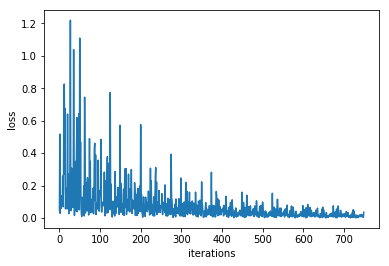

In [16]:
############## CLASSIFIER II : 

#dataset_A_hold.shape,targets_A_hold.shape

X_train = np.reshape(dataset_A_train_2,[dataset_A_train_2.shape[0],1,dataset_A_train_2.shape[1],dataset_A_train_2.shape[2]]).astype('float32')
y_train = np.reshape(targets_A_train_2,[targets_A_train_2.shape[0],1]).astype('float32')

#X_val = np.reshape(dataset_A_hold_2,[dataset_A_hold_2.shape[0],1,dataset_A_hold_2.shape[1],dataset_A_hold_2.shape[2]]).astype('float32') 
#y_val = np.reshape(targets_A_hold_2,[targets_A_hold_2.shape[0],1]).astype('float32')



print (X_train.shape)

print ('-------------')
print (y_train.shape)

print('------------------------------')
print (X_val.shape)

print ('-------------')
print (y_val.shape)


running_loss_array=[]

for epoch in range(Epochs):  # loop over the dataset multiple times
    
    print ("\nEpoch ", epoch)
   # print ('range',int(len(X_train)/batch_size-1))
    train_loss=train(epoch,X_train,y_train)
    prediction2, valid_results=valid(net,epoch,X_val,y_val)
    pred2, test_results=valid(net,epoch,X_test,y_test)
    print ('Parameters:["acc", "auc", "recall", "precision","fmeasure"]')
    print ('validation_results',valid_results)
    print ('test_results',test_results)

    #plot loss
plt.plot(train_loss)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

(300, 1, 144, 64)
-------------
(300, 1)
------------------------------
(40, 1, 144, 64)
-------------
(40, 1)

Epoch  0
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.84999999999999998, 0.94249999999999989, 0.80000000000000004, 0.88888888888888884, 0.8421052631578948]
test_results [0.89583333333333337, 0.95342499999999997, 0.84999999999999998, 0.64150943396226412, 0.73118279569892475]

Epoch  1
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.84999999999999998, 0.96250000000000002, 0.80000000000000004, 0.88888888888888884, 0.8421052631578948]
test_results [0.91000000000000003, 0.95775500000000002, 0.83499999999999996, 0.69008264462809921, 0.75565610859728505]

Epoch  2
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.90000000000000002, 0.97000000000000008, 0.84999999999999998, 0.94444444444444442, 0.89473684210526316]
test_results [0.91083333333333338, 0.9571050000000000

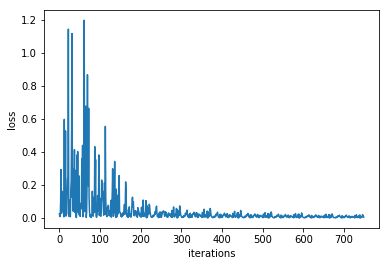

In [17]:
############## CLASSIFIER III : 

#dataset_A_hold.shape,targets_A_hold.shape

X_train = np.reshape(dataset_A_train_3,[dataset_A_train_3.shape[0],1,dataset_A_train_3.shape[1],dataset_A_train_3.shape[2]]).astype('float32')
y_train = np.reshape(targets_A_train_3,[targets_A_train_3.shape[0],1]).astype('float32')

#X_val = np.reshape(dataset_A_hold_3,[dataset_A_hold_3.shape[0],1,dataset_A_hold_3.shape[1],dataset_A_hold_3.shape[2]]).astype('float32') 
#y_val = np.reshape(targets_A_hold_3,[targets_A_hold_3.shape[0],1]).astype('float32')


# make a testing true labels thing for checking accuracy 

print (X_train.shape)

print ('-------------')
print (y_train.shape)

print('------------------------------')
print (X_val.shape)

print ('-------------')
print (y_val.shape)


running_loss_array=[]

for epoch in range(Epochs):  # loop over the dataset multiple times
    
    print ("\nEpoch ", epoch)
   # print ('range',int(len(X_train)/batch_size-1))
    train_loss=train(epoch,X_train,y_train)
    prediction3, valid_results=valid(net,epoch,X_val,y_val)
    pred3, test_results=valid(net,epoch,X_test,y_test)
    print ('Parameters:["acc", "auc", "recall", "precision","fmeasure"]')
    print ('validation_results',valid_results)
    print ('test_results',test_results)
    # Validation accuracy
    #print ("Running Training Loss ", running_loss)
   # print ("Train - ", evaluate(net, X_train, y_train, params))
   # print ("Validation - ", evaluate(net, X_val, y_val, params))
    #print ("Test - ", evaluate(net, X_test, y_test, params))


#plot loss
plt.plot(train_loss)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

(300, 1, 144, 64)
-------------
(300, 1)
------------------------------
(40, 1, 144, 64)
-------------
(40, 1)

Epoch  0
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.92500000000000004, 0.96750000000000003, 0.84999999999999998, 1.0, 0.91891891891891886]
test_results [0.93666666666666665, 0.96068500000000001, 0.81499999999999995, 0.80693069306930698, 0.81094527363184077]

Epoch  1
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.90000000000000002, 0.98999999999999999, 0.84999999999999998, 0.94444444444444442, 0.89473684210526316]
test_results [0.90583333333333338, 0.954565, 0.875, 0.66539923954372626, 0.75593952483801297]

Epoch  2
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.92500000000000004, 0.98999999999999999, 0.90000000000000002, 0.94736842105263153, 0.92307692307692313]
test_results [0.92416666666666669, 0.96123500000000006, 0.84499999999999997, 0.7379912663755

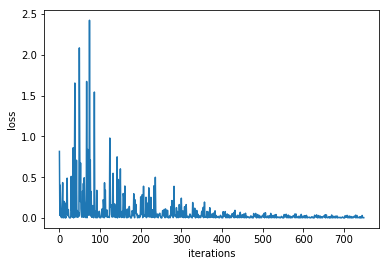

In [18]:
############## CLASSIFIER IV : 

#dataset_A_hold.shape,targets_A_hold.shape

X_train = np.reshape(dataset_A_train_4,[dataset_A_train_4.shape[0],1,dataset_A_train_4.shape[1],dataset_A_train_4.shape[2]]).astype('float32')
y_train = np.reshape(targets_A_train_4,[targets_A_train_4.shape[0],1]).astype('float32')

#X_val = np.reshape(dataset_A_hold_4,[dataset_A_hold_4.shape[0],1,dataset_A_hold_4.shape[1],dataset_A_hold_4.shape[2]]).astype('float32') 
#y_val = np.reshape(targets_A_hold_4,[targets_A_hold_4.shape[0],1]).astype('float32')


print (X_train.shape)

print ('-------------')
print (y_train.shape)

print('------------------------------')
print (X_val.shape)

print ('-------------')
print (y_val.shape)


running_loss_array=[]

for epoch in range(Epochs):  # loop over the dataset multiple times
    
    print ("\nEpoch ", epoch)
   # print ('range',int(len(X_train)/batch_size-1))
    train_loss=train(epoch,X_train,y_train)
    prediction4, valid_results=valid(net,epoch,X_val,y_val)
    pred4, test_results=valid(net,epoch,X_test,y_test)
    print ('Parameters:["acc", "auc", "recall", "precision","fmeasure"]')
    print ('validation_results',valid_results)
    print ('test_results',test_results)
    # Validation accuracy
    #print ("Running Training Loss ", running_loss)
   # print ("Train - ", evaluate(net, X_train, y_train, params))
   # print ("Validation - ", evaluate(net, X_val, y_val, params))
    #print ("Test - ", evaluate(net, X_test, y_test, params))


#plot loss
plt.plot(train_loss)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

(298, 1, 144, 64)
-------------
(298, 1)
------------------------------
(40, 1, 144, 64)
-------------
(40, 1)

Epoch  0
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.92500000000000004, 0.98999999999999999, 0.84999999999999998, 1.0, 0.91891891891891886]
test_results [0.93999999999999995, 0.96480499999999991, 0.77000000000000002, 0.85555555555555551, 0.81052631578947365]

Epoch  1
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.94999999999999996, 0.99249999999999994, 0.90000000000000002, 1.0, 0.94736842105263164]
test_results [0.9425, 0.96845999999999999, 0.81499999999999995, 0.83589743589743593, 0.82531645569620249]

Epoch  2
BS 4
Parameters:["acc", "auc", "recall", "precision","fmeasure"]
validation_results [0.92500000000000004, 0.98999999999999999, 0.90000000000000002, 0.94736842105263153, 0.92307692307692313]
test_results [0.9408333333333333, 0.96907500000000002, 0.83499999999999996, 0.81463414634146336,

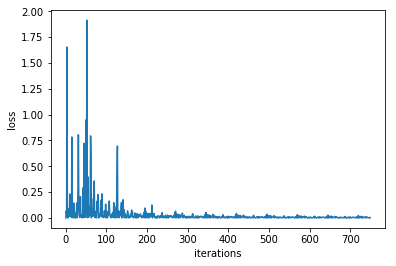

In [19]:
############## CLASSIFIER V : 

#dataset_A_hold.shape,targets_A_hold.shape

X_train = np.reshape(dataset_A_train_5,[dataset_A_train_5.shape[0],1,dataset_A_train_5.shape[1],dataset_A_train_5.shape[2]]).astype('float32')
y_train = np.reshape(targets_A_train_5,[targets_A_train_5.shape[0],1]).astype('float32')

#X_val = np.reshape(dataset_A_hold_5,[dataset_A_hold_5.shape[0],1,dataset_A_hold_5.shape[1],dataset_A_hold_5.shape[2]]).astype('float32') 
#y_val = np.reshape(targets_A_hold_5,[targets_A_hold_5.shape[0],1]).astype('float32')


print (X_train.shape)

print ('-------------')
print (y_train.shape)

print('------------------------------')
print (X_val.shape)

print ('-------------')
print (y_val.shape)


running_loss_array=[]

for epoch in range(Epochs):  # loop over the dataset multiple times
    
    print ("\nEpoch ", epoch)
   # print ('range',int(len(X_train)/batch_size-1))
    train_loss=train(epoch,X_train,y_train)
    prediction5, valid_results=valid(net,epoch,X_val,y_val)
    pred5, test_results=valid(net,epoch,X_test,y_test)
    print ('Parameters:["acc", "auc", "recall", "precision","fmeasure"]')
    print ('validation_results',valid_results)
    print ('test_results',test_results)
  #plot loss
plt.plot(train_loss)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

In [20]:
prediction1[40:42,:]=0
prediction1.shape

(40, 1)

In [21]:
prediction2.shape

(40, 1)

In [22]:
prediction3.shape

(40, 1)

In [23]:
prediction4.shape

(40, 1)

In [24]:
prediction5.shape

(40, 1)

In [25]:
avg_prediction =  (prediction1 + prediction2 + prediction3 + prediction4 + prediction5[0:42,:]) / 5
print (avg_prediction)

[[  8.82457852e-01]
 [  7.17868626e-01]
 [  7.12867677e-02]
 [  9.91149545e-01]
 [  1.35464885e-04]
 [  9.72803712e-01]
 [  9.96339917e-01]
 [  1.21956151e-02]
 [  3.66124898e-01]
 [  1.28358919e-02]
 [  8.99914622e-01]
 [  1.64642986e-02]
 [  9.95988727e-01]
 [  9.99952674e-01]
 [  5.36491461e-02]
 [  7.28374958e-01]
 [  9.98088717e-01]
 [  2.09422275e-01]
 [  8.07511330e-01]
 [  7.42139101e-01]
 [  9.71634057e-04]
 [  3.64736840e-02]
 [  6.21152343e-03]
 [  9.71991897e-01]
 [  9.99708354e-01]
 [  9.39692020e-01]
 [  3.85225475e-01]
 [  2.84635220e-02]
 [  9.87259865e-01]
 [  2.99881041e-01]
 [  6.86704367e-02]
 [  4.69911806e-02]
 [  5.47818886e-03]
 [  2.48482684e-03]
 [  9.12300944e-01]
 [  3.34190488e-01]
 [  1.91751346e-02]
 [  1.17393979e-03]
 [  9.99701679e-01]
 [  8.98787022e-01]]


In [26]:
results=[]
Y=y_val
print (Y.shape)    
for param in ["acc", "auc", "recall", "precision","fmeasure"]:
    if param == 'acc':
        results.append(accuracy_score(Y, np.round(avg_prediction)))
    if param == "auc":
        results.append(roc_auc_score(Y, avg_prediction))
    if param == "recall":
        results.append(recall_score(Y, np.round(avg_prediction)))
    if param == "precision":
        results.append(precision_score(Y, np.round(avg_prediction)))
    if param == "fmeasure":
        precision = precision_score(Y, np.round(avg_prediction))
        recall = recall_score(Y, np.round(avg_prediction))
        results.append(2*precision*recall/ (precision+recall))
print ('Ensemble Result',results)

(40, 1)
Ensemble Result [0.92500000000000004, 0.98249999999999993, 0.90000000000000002, 0.94736842105263153, 0.92307692307692313]


In [27]:
### ENSEMBLE TEST RESULT

In [28]:
############ FPOR TEST SET
avg_pred=  (pred1 + pred2 + pred3 + pred4 + pred5) / 5
print (avg_pred.shape)

(1200, 1)


In [29]:
results_test=[]
Y=y_test
print (Y.shape)
    
for param in ["acc", "auc", "recall", "precision","fmeasure"]:
    if param == 'acc':
        results_test.append(accuracy_score(Y, np.round(avg_pred)))
    if param == "auc":
        results_test.append(roc_auc_score(Y, avg_pred))
    if param == "recall":
        results_test.append(recall_score(Y, np.round(avg_pred)))
    if param == "precision":
        results_test.append(precision_score(Y, np.round(avg_pred)))
    if param == "fmeasure":
        precision = precision_score(Y, np.round(avg_pred))
        recall = recall_score(Y, np.round(avg_pred))
        results_test.append(2*precision*recall/ (precision+recall))
print ('Ensemble Result',results_test)

(1200, 1)
Ensemble Result [0.91249999999999998, 0.96440499999999996, 0.86499999999999999, 0.68924302788844627, 0.76718403547671843]
